In [51]:
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.layers import LSTM
from keras.layers import Embedding
from keras.optimizers import RMSprop


from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras.engine.topology import Input

from sklearn.metrics import accuracy_score
from keras.layers import Concatenate, Merge

import keras
from keras.utils import to_categorical

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [91]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        print("val_loss: ", logs.get('val_loss'))
        print("val_acc: ", logs.get('val_acc'))
        print("loss: ", logs.get('loss'));
        print("acc: ", logs.get('acc'))
        
plot = PlotLearning()

In [92]:
y = np.load("y.npy")
X = np.load("X.npy")

In [93]:
test_size = 500

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

In [95]:
y_train.shape

(1301,)

In [98]:
X_train[0][28:56]

array(['1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0'], dtype='<U32')

In [99]:
X_notes = X_train.T[:28].T
X_notes = np.vstack((X_notes, X_test.T[:28].T))
y_notes = y_train
y_notes = np.append(y_notes, y_test)
X_beats = X_train.T[28:56].T
X_beats = np.vstack((X_beats, X_test.T[28:56].T))
X_chords = X_train.T[56:].T
X_chords = np.vstack((X_chords, X_test.T[56:].T))

In [104]:
X_chords = np.column_stack((X_chords, y_notes.T))
X_chords = X_chords.reshape((-1,1))

In [105]:
chords = np.unique(X_chords)
len(chords)

29

In [106]:
chords_y = np.unique(y)

In [107]:
chords_y

array(['a', 'ad', 'am', 'b', 'bb', 'bm', 'c', 'c#', 'c#d', 'c#m', 'cm',
       'd', 'dm', 'e', 'eb', 'em', 'f', 'f#', 'f#m', 'g', 'gd', 'gm'],
      dtype='<U32')

In [108]:
coded_y = np.array([])

for note in y_notes:
    for i, chord in enumerate(chords):
        if note == chord:
            coded_y = np.append(coded_y, i)

            
            

In [109]:
coded_X_chords = np.array([])

for x_chord in X_chords:
    for i, chord in enumerate(chords):
        if x_chord == chord:
            coded_X_chords = np.append(coded_X_chords, i)

            
            

In [110]:
X_chords = coded_X_chords.reshape((1801,-1))
y_notes = coded_y

In [111]:
np.unique(X_notes)

array(['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='<U32')

In [118]:
X_1 = X_chords[:-test_size]
X_1_test = X_chords[-test_size:]

In [119]:
X_2 = X_notes[:-test_size]
X_2_test = X_notes[-test_size:]

In [120]:
X_3 = X_beats[:-test_size]
X_3_test = X_beats[-test_size:]

In [121]:
y = y_notes[:-test_size]
y_test = y_notes[-test_size:]

In [122]:
X_1.shape

(1301, 29)

In [123]:
X_2.shape

(1301, 28)

In [148]:
model_beat = Sequential()
model_beat.add(Embedding(2, 20, input_length=28))

In [149]:
model_chords = Sequential()
model_chords.add(Embedding(29, 20, input_length=29))
model_chords.add(LSTM(20))

In [151]:
model_notes = Sequential()
model_notes.add(Embedding(13, 20, input_length=28))

model_notes_beats = Sequential()
model_notes_beats.add(Merge([model_notes, model_beat], mode='concat'))
model_notes_beats.add(LSTM(20))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """


In [139]:
np.unique(y)

array([ 0.,  3.,  4.,  5.,  6.,  7.,  9., 10., 11., 12., 14., 15., 16.,
       19., 20., 21., 22., 24., 27., 28.])

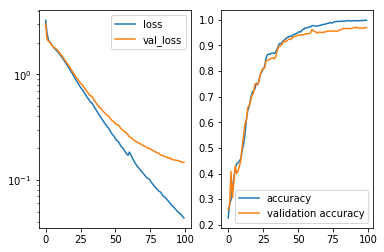

val_loss:  0.14697298519313334
val_acc:  0.9699999988079071
loss:  0.043606382781077035
acc:  0.9984627201591978


In [152]:
merged_model = Sequential()
merged_model.add(Merge([model_chords, model_notes_beats], mode="concat"))
merged_model.add(Dense(29, activation='softmax'))
merged_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
merged_model.fit([X_1, X_2, X_3], y, batch_size=50, epochs=100, verbose=1, 
                 callbacks=[plot], validation_data=[[X_1_test, X_2_test, X_3_test,], y_test])